# module

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy import integrate
import os,os.path
import matplotlib.cm as cm
import glob
from pathlib import Path
import pandas as pd

In [88]:
X_OFFSET = 0.16 # to control how far the scale is from the plot (axes coordinates)
def add_scale(ax):
    rect = ax.get_position()
    rect = (rect.xmin-X_OFFSET, rect.ymin+rect.height/2, # x, y
            rect.width, rect.height/2) # width, height
    scale_ax = ax.figure.add_axes(rect)
    for loc in ['right', 'top', 'bottom']:
        scale_ax.spines[loc].set_visible(False)
    scale_ax.tick_params(bottom=False, labelbottom=False)
    scale_ax.patch.set_visible(False) # hide white background
    scale_ax.spines['left'].set_bounds(*ax.get_ylim())
    scale_ax.set_yticks(ax.get_yticks())
    scale_ax.set_ylim(ax.get_rorigin(), ax.get_rmax())

def confirm(a):
    print(a)

In [89]:
import numpy as np

def confirm(a):
    print(a)

'''Zeeman energy'''
def cal_EZee(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return -M*H*(np.sin(Theta)*np.sin(ThetaH)*np.cos(Phi-PhiH)+np.cos(Theta)*np.cos(ThetaH))

def cal_dEZeedth(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return -M*H*(np.cos(Theta)*np.sin(ThetaH)*np.cos(Phi-PhiH)-np.sin(Theta)*np.cos(ThetaH))

def cal_dEZeedph(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return M*H*np.sin(Theta)*np.sin(ThetaH)*np.sin(Phi-PhiH)

def cal_d2EZeedth2(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return M*H*(np.sin(Theta)*np.sin(ThetaH)*np.cos(Phi-PhiH)+np.cos(Theta)*np.cos(ThetaH))

def cal_d2EZeedph2(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return M*H*np.sin(Theta)*np.sin(ThetaH)*np.cos(Phi-PhiH)

def cal_d2EZeedthdph(theta,phi,M,H,thetaH,phiH):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    ThetaH=np.radians(thetaH)
    PhiH=np.radians(phiH)
    return M*H*np.cos(Theta)*np.sin(ThetaH)*np.sin(Phi-PhiH)

'''First magnetocrystalline anisotropy energy'''
def cal_Emc1(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    Emc1 = np.zeros((len(phi)))
    for i in range(3):
        Emc1 = Emc1 + K1*a[i%3]**2*a[(i+1)%3]**2
    return Emc1

def cal_dEmc1dth(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    dEmc1dth = np.zeros((len(phi)))
    for i in range(3):
        dEmc1dth = dEmc1dth + K1*2*a[i%3]*a[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
    return dEmc1dth

def cal_dEmc1dph(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    dEmc1dph = np.zeros((len(phi)))
    for i in range(3):
        dEmc1dph = dEmc1dph + K1*2*a[i%3]*a[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
    return dEmc1dph

def cal_d2Emc1dth2(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    att= [-np.sin(Theta)*np.cos(Phi), -np.sin(Theta)*np.sin(Phi), -np.cos(Theta)]
    d2Emc1dth2 = np.zeros((len(phi)))
    for i in range(3):
        d2Emc1dth2 = d2Emc1dth2 + K1*2*at[i%3]*a[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dth2 = d2Emc1dth2 + K1*2*a[i%3]*at[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dth2 = d2Emc1dth2 + K1*2*a[i%3]*a[(i+1)%3]*(att[i%3]*a[(i+1)%3]+2*at[i%3]*at[(i+1)%3]+a[i%3]*att[(i+1)%3])
    return d2Emc1dth2

def cal_d2Emc1dph2(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    att= [-np.sin(Theta)*np.cos(Phi), -np.sin(Theta)*np.sin(Phi), 0]
    d2Emc1dph2 = np.zeros((len(phi)))
    for i in range(3):
        d2Emc1dph2 = d2Emc1dph2 + K1*2*at[i%3]*a[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dph2 = d2Emc1dph2 + K1*2*a[i%3]*at[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dph2 = d2Emc1dph2 + K1*2*a[i%3]*a[(i+1)%3]*(att[i%3]*a[(i+1)%3]+2*at[i%3]*at[(i+1)%3]+a[i%3]*att[(i+1)%3])
    return d2Emc1dph2

def cal_d2Emc1dthdph(theta,phi,K1):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    ap = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    atp= [-np.cos(Theta)*np.sin(Phi), np.cos(Theta)*np.cos(Phi), 0]
    d2Emc1dthdph = np.zeros((len(phi)))
    for i in range(3):
        d2Emc1dthdph = d2Emc1dthdph + K1*2*ap[i%3]*a[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dthdph = d2Emc1dthdph + K1*2*a[i%3]*ap[(i+1)%3]*(at[i%3]*a[(i+1)%3]+a[i%3]*at[(i+1)%3])
        d2Emc1dthdph = d2Emc1dthdph + K1*2*a[i%3]*a[(i+1)%3]*(atp[i%3]*a[(i+1)%3]+at[i%3]*ap[(i+1)%3]+ap[i%3]*at[(i+1)%3]+a[i%3]*atp[(i+1)%3])
    return d2Emc1dthdph

'''uniaxial perpendicular energy (demagnetization energy)'''
def cal_Euni(theta, Ku):
    Theta=np.radians(theta)
    return Ku*np.cos(Theta)**2

def cal_dEunidth(theta, Ku):
    Theta=np.radians(theta)
    return -Ku*np.sin(2*Theta)

def cal_d2Eunidth2(theta, Ku):
    Theta=np.radians(theta)
    return -2*Ku*np.cos(2*Theta)

def cal_dEunidph(theta, Ku):
    return 0

def cal_d2Eunidph2(theta, Ku):
    return 0

def cal_d2Eunidthdph(theta, Ku):
    return 0


'''Magnetoelastic energy'''
def cal_Emel(theta,phi,Ke):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    Emel = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            Emel = Emel + Ke[i,j]*a[i]*a[j]
    return Emel

def cal_dEmeldth(theta,phi,Ke):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    dEmeldth = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            dEmeldth = dEmeldth + Ke[i,j]*(at[i]*a[j]+a[i]*at[j])
    return dEmeldth

def cal_dEmeldph(theta,phi,Ke):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    dEmeldph = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            dEmeldph = dEmeldph + Ke[i,j]*(at[i]*a[j]+a[i]*at[j])
    return dEmeldph

def cal_d2Emeldth2(theta,phi,Ke):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    att= [-np.sin(Theta)*np.cos(Phi), -np.sin(Theta)*np.sin(Phi), -np.cos(Theta)]
    d2Emeldth2 = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            d2Emeldth2 = d2Emeldth2 + Ke[i,j]*(att[i]*a[j]+2*at[i]*at[j]+a[i]*att[j])
    return d2Emeldth2

def cal_d2Emeldph2(theta,phi,Ke):
    Theta=np.radians(theta)
    Phi=np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    att= [-np.sin(Theta)*np.cos(Phi), -np.sin(Theta)*np.sin(Phi), 0]
    d2Emeldph2 = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            d2Emeldph2 = d2Emeldph2 + Ke[i,j]*(att[i]*a[j]+2*at[i]*at[j]+a[i]*att[j])
    return d2Emeldph2

def cal_d2Emeldthdph(theta,phi,Ke):
    Theta = np.radians(theta)
    Phi = np.radians(phi)
    a  = [np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)]
    at = [np.cos(Theta)*np.cos(Phi), np.cos(Theta)*np.sin(Phi), -np.sin(Theta)]
    ap = [-np.sin(Theta)*np.sin(Phi), np.sin(Theta)*np.cos(Phi), 0]
    atp= [-np.cos(Theta)*np.sin(Phi), np.cos(Theta)*np.cos(Phi), 0]
    d2Emeldthdph = np.zeros((len(phi)))
    for i in range(3):
        for j in range(3):
            d2Emeldthdph = d2Emeldthdph + Ke[i,j]*(atp[i]*a[j]+at[i]*ap[j]+ap[i]*at[j]+a[i]*atp[j])
    return d2Emeldthdph

'''2 fold symetric function'''
def cal_d2E2fsdth2(phi,K2f,phiK2f):
    return 0

def cal_dE2fsdph(phi,K2f,phiK2f):
    Phi = np.radians(phi)
    PhiK2f = np.radians(phiK2f)
    return K2f*np.sin(2*(Phi-PhiK2f))

def cal_d2E2fsdph2(phi,K2f,phiK2f):
    Phi = np.radians(phi)
    PhiK2f = np.radians(phiK2f)
    return -2*K2f*np.cos(2*(Phi-PhiK2f))
"""
def cal_d2E2fsdph3(phi,K2f,phiK2f):
    Phi = np.radians(phi)
    PhiK2f = np.radians(phiK2f)
    return K2f*(np.sin(Phi-PhiK2f))**2
"""
'''4 fold symetric function'''
def cal_d2E4fsdth2(phi,K4f):
    return 0

def cal_dE4fsdph(phi,K4f):
    Phi = np.radians(phi)
    return -4*K4f*np.sin(4*Phi)

def cal_d2E4fsdph2(phi,K4f):
    Phi = np.radians(phi)
    return -16*K4f*np.cos(4*Phi)

'''8 fold symetric function'''
def cal_d2E8fsdth2(phi,K8f,phiK8f):
    return 0

def cal_dE8fsdph(phi,K8f,phiK8f):
    Phi = np.radians(phi)
    PhiK8f = np.radians(phiK8f)
    return -8*K8f*np.sin(8*(Phi-PhiK8f))

def cal_d2E8fsdph2(phi,K8f,phiK8f):
    Phi = np.radians(phi)
    PhiK8f = np.radians(phiK8f)
    return -64*K8f*np.cos(8*(Phi-PhiK8f))

'''basic equations'''
def quadratic_equation_p(a,b,c):
    return (-b+np.sqrt(b**2-4*a*c))/(2*a)

def quadratic_equation_n(a,b,c):
    return (-b-np.sqrt(b**2-4*a*c))/(2*a)

'''resonance field'''
def fit_Hresonance(phiH,thetaH,phi,theta,M,f,gamma,Ku,K1,Ke11,Ke22,Ke12):
    Ke = np.array([[Ke11, Ke12, 0],[Ke12, Ke22, 0],[0, 0, 0]])
    d2EZeedth2 = cal_d2EZeedth2(theta,phi,M,1,thetaH,phiH)
    d2EZeedph2 = cal_d2EZeedph2(theta,phi,M,1,thetaH,phiH)
    d2EZeedthdph = cal_d2EZeedthdph(theta,phi,M,1,thetaH,phiH)
    d2Emdth2 = cal_d2Emc1dth2(theta,phi,K1) + cal_d2Eunidth2(theta, Ku) + cal_d2Emeldth2(theta,phi,Ke)
    d2Emdph2 = cal_d2Emc1dph2(theta,phi,K1) + cal_d2Eunidph2(theta, Ku) + cal_d2Emeldph2(theta,phi,Ke)
    d2Emdthdph = cal_d2Emc1dthdph(theta,phi,K1) + cal_d2Eunidthdph(theta, Ku) + cal_d2Emeldthdph(theta,phi,Ke)
    omega = 2*np.pi*f
    A = d2EZeedth2*d2EZeedph2-d2EZeedthdph**2
    B = d2EZeedth2*d2Emdph2+d2Emdth2*d2EZeedph2-2*d2EZeedthdph*d2Emdthdph
    C = d2Emdth2*d2Emdph2-d2Emdthdph**2-(omega/gamma)**2*(M*np.sin(np.radians(theta)))**2
    return quadratic_equation_p(A,B,C)

#8回対称成分考慮しないver

def fit_Hresonance2(phiH,thetaH,phi,theta,M,f,gamma,Ku,K1,K2f,phiK2f):
    d2EZeedth2 = cal_d2EZeedth2(theta,phi,M,1,thetaH,phiH)
    d2EZeedph2 = cal_d2EZeedph2(theta,phi,M,1,thetaH,phiH)
    d2EZeedthdph = cal_d2EZeedthdph(theta,phi,M,1,thetaH,phiH)
    d2Emdth2 = cal_d2Emc1dth2(theta,phi,K1) + cal_d2Eunidth2(theta, Ku)
    d2Emdph2 = cal_d2Emc1dph2(theta,phi,K1) + cal_d2E2fsdph2(phi,K2f,phiK2f)
    d2Emdthdph = cal_d2Emc1dthdph(theta,phi,K1) + cal_d2Eunidthdph(theta, Ku)
    omega = 2*np.pi*f
    A = d2EZeedth2*d2EZeedph2-d2EZeedthdph**2
    B = d2EZeedth2*d2Emdph2+d2Emdth2*d2EZeedph2-2*d2EZeedthdph*d2Emdthdph
    C = d2Emdth2*d2Emdph2-d2Emdthdph**2-(omega/gamma)**2*(M*np.sin(np.radians(theta)))**2
    return quadratic_equation_p(A,B,C)


# analysis

In [101]:
path = '/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/IP-FMR'
samplename = '231013ni1a-ipfmr240416'
date='220224d-ni-ipfmr'
Ms = 429 #飽和磁化の大きさを入力
K1 = -100000
#初期値の入力

data number： 121


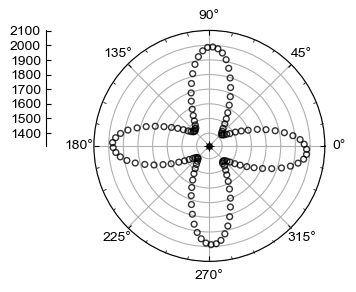

In [109]:
f = open(f'{path}/{samplename}.txt', 'rt')

x_list=[]  #phi_H(degree)
y_list=[]  #H_R(Oe)
xraw_list=[]

d=-53 #phiのずれを調整(K1<0なら+45 deg)

n=0
for line in f :
    n=n+1
    data = line[:-1].split('\t')
    x_list.append(float(data[0])+d)
    y_list.append(float(data[1])*10)
    xraw_list.append(float(data[0]))
print('data number：',n)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 10

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection="polar")
plt.scatter(np.radians(x_list),y_list,marker='.',color='none',edgecolor='black',s=70, alpha=0.8)

Rmax = max(y_list)
Rmin = min(y_list)
dR = (Rmax - Rmin)/100*20
ax.set_ylim(Rmin-dR,Rmax+dR)
# ax.set_ylim(600,1100)
ax.xaxis.set_ticks_position('both')
ax.set_axisbelow(True)
plt.yticks(color="None")
plt.minorticks_on()
add_scale(ax)

In [110]:
len_data = len(x_list)
Hr = y_list
thetaH = [90]*len_data #degree
phiH = x_list
theta = thetaH 
freq = 9.36*10**9 #frequency Hz
muB = 9.274*10**(-21) #Bhor magnetron erg/Oe
hbar = 1.0456*10**(-27) #Dirac constant erg*s

index_100 = [i for i,th in enumerate(phiH) if (th//45)%2 == 0 and th % 45 < 3]#phih = 0, 90, 180, 270
index_110 = [i for i,th in enumerate(phiH) if (th//45)%2 == 1 and th % 45 < 3] #phiH = 45, 135, 225, 315

Hr_100 = 0
Hr_110 = 0
for i,j in zip(index_100,index_110):
    Hr_100 += Hr[i]/4
    Hr_110 += Hr[j]/4
print(Hr_100, Hr_110)

g = 2 #g-factor
gamma = g*muB/hbar #magnetic rotation ratio
a = 2*np.pi*freq/gamma

def func(x):
    b = x[0]
    c = x[1]
    X0 = a**2 - (Hr_100+2*b+c)*(Hr_100+2*b)
    X1 = a**2 - (Hr_110+b+c)*(Hr_110-2*b)
    return [X0, X1]

result = optimize.root(func, [80, 14000], method="broyden1")
print(result)
K1 = result.x[0]*Ms
Ku = result.x[1]*Ms/2
print('K1 guess: ',K1)
print('Ku guess: ',Ku)

1975.5058290000002 1443.2220457499998
 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-7.451e-09  5.588e-09]
       x: [-1.579e+02  4.963e+03]
     nit: 13
K1 guess:  -67751.75711184938
Ku guess:  1064567.213038714


## 8回対称成分なしver

num,gamma, Ku, K1, K2f, phiK2fs
0 [17739097.16908951, 1064567.213038714, -67751.75711184938, 2140.004617056471, 28]
0 0 [17751650.143839415, 1064268.2197125382, -67751.75711184938, -4986.648902536931, 34.731475071855634]
0 0 [14847.900906372626, 2270.743756577197, 0, 836.1506504923392, 5.14283115924553] Error
1 0 [17755150.388820093, 1063986.6766944386, -67751.75711184938, -5884.508258929397, 39.04419321898093]
1 0 [15301.282103328771, 2335.658904099919, 0, 855.3122773505931, 4.515683992198504] Error
2 0 [17757245.3279133, 1063709.3774444675, -67751.75711184938, -6085.975929757926, 38.68401726069433]
2 0 [15391.326968528143, 2347.9276891557256, 0, 860.6244602522993, 4.389229625467595] Error
3 0 [17759105.604325116, 1063432.122839379, -67751.75711184938, -6111.457004360217, 38.814856926420504]
3 0 [15411.439170000438, 2350.188326173435, 0, 861.5073496594302, 4.376937590453906] Error
4 0 [17760911.100207146, 1063154.3600662567, -67751.75711184938, -6117.717262963247, 38.79895658753208]
4

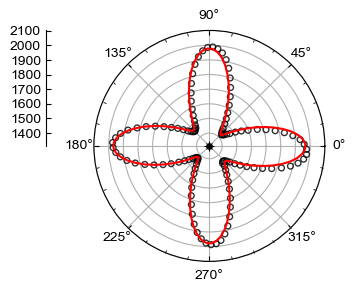

In [111]:
#8回対称成分考慮しないver
def fit_Hresonance2(phiH,thetaH,phi,theta,M,f,gamma,Ku,K1,K2f,phiK2f):
    d2EZeedth2 = cal_d2EZeedth2(theta,phi,M,1,thetaH,phiH)
    d2EZeedph2 = cal_d2EZeedph2(theta,phi,M,1,thetaH,phiH)
    d2EZeedthdph = cal_d2EZeedthdph(theta,phi,M,1,thetaH,phiH)
    d2Emdth2 = cal_d2Emc1dth2(theta,phi,K1) + cal_d2Eunidth2(theta, Ku)
    d2Emdph2 = cal_d2Emc1dph2(theta,phi,K1) + cal_d2E2fsdph2(phi,K2f,phiK2f)
    d2Emdthdph = cal_d2Emc1dthdph(theta,phi,K1) + cal_d2Eunidthdph(theta, Ku)
    omega = 2*np.pi*f
    A = d2EZeedth2*d2EZeedph2-d2EZeedthdph**2
    B = d2EZeedth2*d2Emdph2+d2Emdth2*d2EZeedph2-2*d2EZeedthdph*d2Emdthdph
    C = d2Emdth2*d2Emdph2-d2Emdthdph**2-(omega/gamma)**2*(M*np.sin(np.radians(theta)))**2
    return quadratic_equation_p(A,B,C)


K2f = 2140.004617056471
phiK2fs = 28
#K8f = 100
phig = 25.5


para = [[gamma, Ku, K1, K2f, phiK2fs]]
print("num,gamma, Ku, K1, K2f, phiK2fs")
print(0, para[0])

for i in range(5):
    gammai = para[i][0]
    Kui = para[i][1]
    K1i = para[i][2]
    #K1i = K1
    K2fi = para[i][3]
    phiK2fsi = para[i][4]
    phii = []
    # calculate theta and phi when enery become min
    for j, h in enumerate(Hr):
        eta = 0.00001
        max_iter = 1000
        phi0 = phiH[j] - 1
        for k in range(max_iter):
            dF = cal_dEZeedph([theta[j]],[phi0],Ms,h,[thetaH[j]],[phiH[j]]) + cal_dEmc1dph([theta[j]],[phi0],K1i) + cal_dE2fsdph(phi0,K2fi,phiK2fsi)
            #print(k, eta*dF)
            if np.abs(eta*dF) < 0.00001:
                break
            else:
                phi0 = phi0 - eta * dF[0]
                if k == max_iter-1:
                    print(i,j,'no break')
            #print(phi0)
        phii.append(phi0)
        #print(phiH[j], phi0)

    for j in range(1):
        guess = [gammai,K1i,K2fi,phiK2fsi]
        poptHR, pcovHR = curve_fit(lambda phiH,gammai,K1i,K2fi,phiK2fsi :fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,gammai,Kui,K1i,K2fi,phiK2fsi),phiH,Hr,p0=guess,maxfev = 50000)
        perrHr=np.sqrt(np.diag(pcovHR))
        gammaif = poptHR[0]
        K1if = poptHR[1]
        K1if = K1
        K2fif = poptHR[2]
        phiK2fsif = poptHR[3]
        
        gammaiferr = perrHr[0]
        K1iferr = perrHr[1]
        K1iferr = 0
        K2fiferr = perrHr[2]
        phiK2fsiferr = perrHr[3]
        ###
        guess = [Kui]
        poptHR1, pcovHR1 = curve_fit(lambda phiH,Kui :fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,gammaif,Kui,K1if,K2fif,phiK2fsif),phiH,Hr,p0=guess,maxfev = 50000)
        perrHR1=np.sqrt(np.diag(pcovHR1))
        Kuif = poptHR1[0]
        Kuiferr = perrHR1[0]
        
        #
        print(i,j, [gammaif,Kuif,K1if,K2fif,phiK2fsif])
        print(i,j, [gammaiferr,Kuiferr,K1iferr,K2fiferr,phiK2fsiferr],"Error")
    para.append([gammaif,Kuif,K1if,K2fif,phiK2fsif])
#np.save(f'{path}/{samplename}/analysis/poptHR.npy',np.array(poptHR))
#np.save(f'{path}/{samplename}/analysis/pcovHR.npy',np.array(pcovHR))

#'''
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection="polar")

Hr_test = fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,*para[-1])
plt.scatter(np.radians(phiH),Hr,marker='.',color='none',edgecolor='black',s=70, alpha=0.8)
plt.plot(np.radians(phiH),Hr_test,color='red')

Rmax = max(y_list)
Rmin = min(y_list)
dR = (Rmax - Rmin)/100*20
ax.set_ylim(Rmin-dR,Rmax+dR)
ax.xaxis.set_ticks_position('both')
ax.set_axisbelow(True)
plt.yticks(color="None")
plt.minorticks_on()
add_scale(ax)

##########データファイルの作成##################################################
with open(f'{path}/fitteddata/fitted_{samplename}_{date}.txt','a') as f:
    f.write(f"d \t\t:{d}\n\n")
    f.write(f"fitted gamma \t\t:{poptHR[0]:.4e}\t ± {perrHr[0]:.4e}\n\n")
    f.write(f"fitted Ku (erg/cc) \t\t:{poptHR1[0]:.4e}\t ± {perrHR1[0]:.4e}\n")
    f.write(f"fitted K1 (erg/cc) \t:{poptHR[1]:.4e}\t ± {perrHr[1]:.4e}\n")
    f.write(f"fitted K2 (erg/cc) \t:{poptHR[2]:.4e}\t ± {perrHr[2]:.4e}\n")
    f.write(f"fitted phi (deg.) \t:{poptHR[3]:.4e}\t ± {perrHr[3]:.4e}\n")
    f.write("\n")

fig.savefig(f'{path}/Fig/c_{samplename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{path}/Fig/c_{samplename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

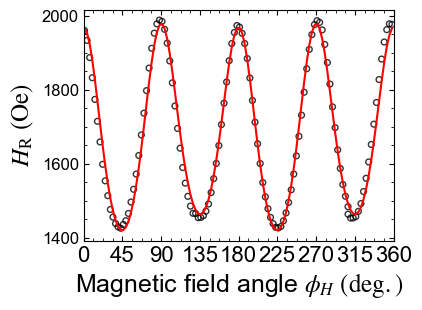

In [112]:
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

phiH_fix = []
for pH in phiH:
    phiH_fix.append(pH%360)

zip_lists = zip(phiH_fix, Hr, Hr_test)
zip_sort = sorted(zip_lists)
phiH_fix, Hr_fix, Hr_test_fix = zip(*zip_sort)

plt.scatter(phiH_fix,Hr_fix,marker='.',color='none',edgecolor='black',s=70, alpha=0.8)
plt.plot(phiH_fix,Hr_test_fix,color='red')

plt.xlim(0,360)
plt.xticks(np.arange(0,361,45), fontsize=16)
#plt.yticks(np.arange(1000,2801,400), fontsize=16)
plt.minorticks_on()
#plt.grid(True)
plt.xlabel('Magnetic field angle $\phi_H\ (\mathrm{deg.})$', fontsize=18)
plt.ylabel('$H_\mathrm{R}\ (\mathrm{Oe})$', fontsize=18)

fig.savefig(f'{path}/Fig/{samplename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{path}/Fig/{samplename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

## 8回対称成分考慮ver

num,gamma, Ku, K1, K2f, phiK2fs ,K8f, phiK8fs
0 [17739097.16908951, 3653370.982465693, -1373.2903013526345, 3000, 0, 100, 25.5]
0 0 [17760296.12157171, 3653370.982444597, -1297.0599567596005, 279.46551084587543, 0, -30.777837585955776, 25.5]
1 0 [17760243.896304846, 3653370.9825563026, -1297.5920331472628, 268.01201225936376, 0, -30.522397627301135, 25.5]
2 0 [17760244.472590145, 3653370.9825563026, -1297.6260029143982, 267.961576991011, 0, -30.521554943233387, 25.5]
3 0 [17760244.4906885, 3653370.9825967327, -1297.6349984700212, 267.9594605159568, 0, -30.52172100184747, 25.5]
4 0 [17760244.455005027, 3653370.9825967327, -1297.6168065315414, 267.9637810179884, 0, -30.521253642653246, 25.5]


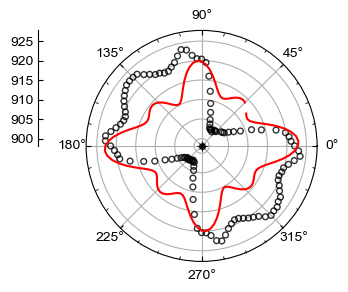

In [211]:
#8回対称成分考慮ver
def fit_Hresonance2(phiH,thetaH,phi,theta,M,f,gamma,Ku,K1,K2f,phiK2f,K8f,phiK8f):
    d2EZeedth2 = cal_d2EZeedth2(theta,phi,M,1,thetaH,phiH)
    d2EZeedph2 = cal_d2EZeedph2(theta,phi,M,1,thetaH,phiH)
    d2EZeedthdph = cal_d2EZeedthdph(theta,phi,M,1,thetaH,phiH)
    d2Emdth2 = cal_d2Emc1dth2(theta,phi,K1) + cal_d2Eunidth2(theta, Ku)
    d2Emdph2 = cal_d2Emc1dph2(theta,phi,K1) + cal_d2E2fsdph2(phi,K2f,phiK2f) + cal_d2E8fsdph2(phi,K8f,phiK8f)
    d2Emdthdph = cal_d2Emc1dthdph(theta,phi,K1) + cal_d2Eunidthdph(theta, Ku)
    omega = 2*np.pi*f
    A = d2EZeedth2*d2EZeedph2-d2EZeedthdph**2
    B = d2EZeedth2*d2Emdph2+d2Emdth2*d2EZeedph2-2*d2EZeedthdph*d2Emdthdph
    C = d2Emdth2*d2Emdph2-d2Emdthdph**2-(omega/gamma)**2*(M*np.sin(np.radians(theta)))**2
    return quadratic_equation_p(A,B,C)

K2f = 3000
phiK2fs = 0
K8f = 100
phiK8fs = 25.5

print("num,gamma, Ku, K1, K2f, phiK2fs ,K8f, phiK8fs")
para = [[gamma, Ku, K1, K2f, phiK2fs, K8f, phiK8fs]]
print(0, para[0])


for i in range(5):
    gammai = para[i][0]
    Kui = para[i][1]
    K1i = para[i][2]
    K2fi = para[i][3]
    K8fi = para[i][4]
    
    phii = []
    # calculate theta and phi when enery become min
    for j, h in enumerate(Hr):
        eta = 0.00001
        max_iter = 1000
        phi0 = phiH[j] - 1
        for k in range(max_iter):
            dF = cal_dEZeedph([theta[j]],[phi0],Ms,h,[thetaH[j]],[phiH[j]]) + cal_dEmc1dph([theta[j]],[phi0],K1i) + cal_dE2fsdph(phi0,K2fi,phiK2fs) + cal_dE8fsdph(phi0,K8fi,phiK8fs)
            #print(k, eta*dF)
            if np.abs(eta*dF) < 0.00001:
                break
            else:
                phi0 = phi0 - eta * dF[0]
                if k == max_iter-1:
                    print(i,j,'no break')
            #print(phi0)
        phii.append(phi0)
        #print(phiH[j], phi0)

    for j in range(1):
        guess = [gammai,K1i,K2fi, K8fi]
        poptHR, pcovHR = curve_fit(lambda phiH,gammai,K1i,K2fi,K8fi :fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,gammai,Kui,K1i,K2fi,phiK2fs,K8fi,phiK8fs),phiH,Hr,p0=guess,maxfev = 50000)
        perrHr=np.sqrt(np.diag(pcovHR))
        gammaif = poptHR[0]
        K1if = poptHR[1]
        K2fif = poptHR[2]
        K8fif = poptHR[3]
        ###
        guess = [Kui]
        poptHR1, pcovHR1 = curve_fit(lambda phiH,Kui :fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,gammaif,Kui,K1if,K2fif,phiK2fs,K8fif,phiK8fs),phiH,Hr,p0=guess,maxfev = 50000)
        perrHR1=np.sqrt(np.diag(pcovHR))
        Kuif = poptHR1[0]
        #
        print(i,j, [gammaif,Kuif,K1if,K2fif,phiK2fs,K8fif,phiK8fs])
    para.append([gammaif,Kuif,K1if,K2fif,phiK2fs,K8fif,phiK8fs])
#np.save(f'{path}/{samplename}/analysis/poptHR.npy',np.array(poptHR))
#np.save(f'{path}/{samplename}/analysis/pcovHR.npy',np.array(pcovHR))

#'''
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection="polar")

Hr_test = fit_Hresonance2(phiH,thetaH,phii,thetaH,Ms,freq,*para[-1])
plt.scatter(np.radians(phiH),Hr,marker='.',color='none',edgecolor='black',s=70, alpha=0.8)
plt.plot(np.radians(phiH),Hr_test,color='red')

Rmax = max(y_list)
Rmin = min(y_list)
dR = (Rmax - Rmin)/100*20
ax.set_ylim(Rmin-dR,Rmax+dR)
ax.xaxis.set_ticks_position('both')
ax.set_axisbelow(True)
plt.yticks(color="None")
plt.minorticks_on()
add_scale(ax)

##########データファイルの作成##################################################
with open(f'{path}/fitteddata/fitted8fs_{samplename}_{date}.txt','a') as f:
    f.write(f"fitted gamma \t\t:{poptHR[0]:.4e}\t ± {perrHr[0]:.4e}\n\n")
    f.write(f"fitted Ku (erg/cc) \t\t:{poptHR1[0]:.4e}\t ± {perrHR1[0]:.4e}\n")
    f.write(f"fitted K1 (erg/cc) \t:{poptHR[1]:.4e}\t ± {perrHr[1]:.4e}\n")
    f.write(f"fitted K2 (erg/cc) \t:{poptHR[2]:.4e}\t ± {perrHr[2]:.4e}\n")
    f.write(f"fitted K8 (erg/cc) \t:{poptHR[3]:.4e}\t ± {perrHr[3]:.4e}\n")
    f.write("\n")

fig.savefig(f'{path}/Fig/8fs/c_8fs_{samplename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{path}/Fig/8fs/c_8fs_{samplename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

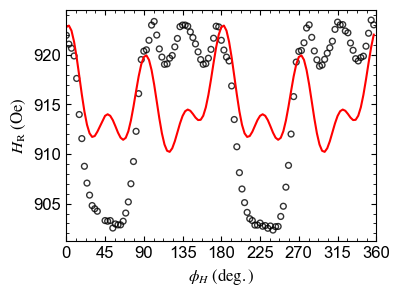

In [191]:
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

phiH_fix = []
for pH in phiH:
    phiH_fix.append(pH%360)

zip_lists = zip(phiH_fix, Hr, Hr_test)
zip_sort = sorted(zip_lists)
phiH_fix, Hr_fix, Hr_test_fix = zip(*zip_sort)

plt.scatter(phiH_fix,Hr_fix,marker='.',color='none',edgecolor='black',s=70, alpha=0.8)
plt.plot(phiH_fix,Hr_test_fix,color='red')

plt.xlim(0,360)
plt.xticks(np.arange(0,361,45))
plt.minorticks_on()
#plt.grid(True)
plt.xlabel('$\phi_H\ (\mathrm{deg.})$')
plt.ylabel('$H_\mathrm{R}\ (\mathrm{Oe})$')

fig.savefig(f'{path}/Fig/8fs/8fs_{samplename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{path}/Fig/8fs/8fs_{samplename}.png',format="png", bbox_inches="tight", pad_inches=0.1)